### ITR BENCHMARK (Non-parametric)



---
---
Florie Brion Bouvier<br>
Etienne Peyrot<br>
Alan Balendran<br>



1. [Dataset](#part1)
1. [S Learner](#part2)
1. [T Learner](#part3)
1. [X Learner](#part4)
1. [Comparison](#part5)

Basically the same notebook as the parametric one, except that linear models are changed with random forests. We also test meta models from `econml`.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.calibration import calibration_curve
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV 
from econml.metalearners import SLearner, TLearner, XLearner

# a voir
from matplotlib.figure import Figure
import os
from tabulate import tabulate
from tqdm import tqdm

In [2]:
## set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

## Dataset <a id="part1"></a>

In [3]:
file_name = 'data/ist-imp.csv'
file_path = '/content/ist-imp.csv'

if not os.path.isfile(file_path) :
    try :
        # upload file for colab user
        from google.colab import files
        uploaded = files.upload()
    except :
        pass

data = pd.read_csv(file_name)

data = data.drop('heparin',axis=1) # Don't need Heparin
hosp_num = data['HOSPNUM'] # will be used to create independent train/test split
data = data.drop('HOSPNUM',axis=1)

In [4]:
data.head(3)

,AGE,RDELAY,SBP,SEX,CTbeforeHosp,CTInfarct,AtrialFib,Asp3d,FaceDef,ArmHandDef,...,Dysphasia,Hemianopia,VSDisorder,CerebSigns,OtherDeficit,Conscious,StrokeType,region,aspirin,deathdep
0,69,17,140,M,Yes,Yes,No,No,No,No,...,Yes,No,Yes,No,Yes,Drowsy,PACS,Europe,1,1
1,76,10,150,M,Yes,No,No,No,Yes,Yes,...,No,No,No,No,No,Fully alert,LACS,Europe,0,1
2,71,43,170,F,Yes,No,No,No,Yes,Yes,...,No,No,No,No,No,Fully alert,LACS,Europe,1,1


**21** variables:<br>
- 19 covariables: ` AGE `,` RDELAY `,` SBP `,` SEX `,` CTbeforeHosp `,` CTInfarct `,` AtrialFib `,` Asp3d `,<br>` FaceDef `,` ArmHandDef `,` LegFootDef `,` Dysphasia `,` Hemianopia `,` VSDisorder `,<br>` CerebSigns `,` OtherDeficit `,` Conscious `,` StrokeType `,` region `
- treatment: `aspirin`
- outcome: `deathdep`

In [5]:
continuous_col = [] 
categorical_col = []

for c in data.columns:
    if data[c].dtype=='object' or c in ['aspirin', 'deathdep']:
        data[c] = data[c].astype('category') ## convert as category
        categorical_col.append(c)
    else:
        continuous_col.append(c)

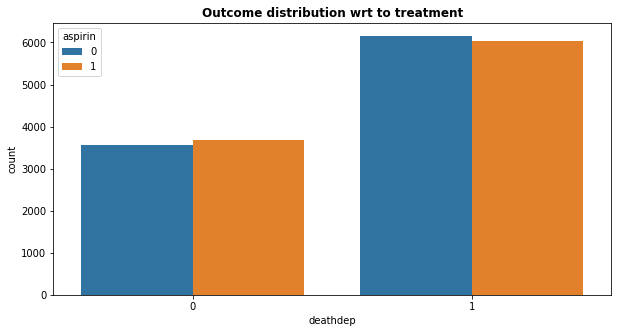

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='deathdep', hue='aspirin')
plt.title('Outcome distribution wrt to treatment', fontweight='bold', fontsize=12);

In [7]:
def preprocessing (data, collins_format:bool = True, interaction_feature:bool = True) :
    df = data.copy()

    if collins_format :
        # get the categorical covariates name
        to_dummies = []
        for c in categorical_col:
            if df[c].nunique()>2:
                to_dummies.append(c)
        
        # drop the reference values (see Collins paper) 
        reference_to_drop = [
            'FaceDef_No',
            'ArmHandDef_No',
            'LegFootDef_No',
            'Dysphasia_No',
            'Hemianopia_No',
            'VSDisorder_No',
            'CerebSigns_No',
            'OtherDeficit_No',
            'Conscious_Fully alert',
            'StrokeType_PACS',
            'region_Europe'
        ]

        # transform categorical covariates into binary covariates
        df_dummies = pd.get_dummies(df[to_dummies])
        df_dummies = df_dummies.drop(reference_to_drop, axis=1)

        to_encode = set(categorical_col)-set(to_dummies)
        df = pd.concat([df,df_dummies], axis=1)
        df = df.drop(to_dummies, axis=1)

        lab_encoder = LabelEncoder() ##encoding categorical features
        for c in to_encode: ## change with to_encode if using dummies
            df[c] = lab_encoder.fit_transform(df[c])
        
    else :
        lab_encoder = LabelEncoder() ##encoding categorical features
        for c in categorical_col: ## change with to_encode if using dummies
            df[c] = lab_encoder.fit_transform(df[c])
    
    no_interaction_covariates = list(df.columns.drop(['aspirin', 'deathdep']))

    if interaction_feature :
        # add treatment interaction with covariates 
        features = no_interaction_covariates
        X_interaction = df[features].mul(df['aspirin'],axis=0)
        X_interaction.columns = [s+'_treatment' for s in X_interaction.columns]
        df = pd.concat([df,X_interaction],axis=1)
    
    # add intercept
    df['intercept'] = 1
    no_interaction_covariates = ['intercept'] + no_interaction_covariates

    return df, no_interaction_covariates

Splitting into train/test by making sure that we do not have the same hospital numbers in both sets.

In [8]:
def data_splitting (df, seed=42) :
    gss = GroupShuffleSplit(n_splits=1, train_size=.66, random_state=seed)
    df_train = None
    df_test = None

    for tr_ind, te_ind in gss.split(df,groups=hosp_num):
        df_train = df.loc[tr_ind]
        df_test = df.loc[te_ind]
    
    return df_train, df_test

In [9]:
## no need for one-hot encoding for trees
df, covariates_collins = preprocessing(data, collins_format=False)
## the seed is choosen so that we end up with the same number of patients in the train/validation set as Collins
df_train, df_test = data_splitting(df, seed=2411)

X = df_train[covariates_collins]
treatment = df_train['aspirin']
y = df_train['deathdep']

Parameters grid for model tuning

In [10]:
parameters = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 10, 20, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

# S learner <a id="part2"></a>

In [11]:
X_s = pd.concat([df_train.drop(['aspirin','deathdep'], axis=1), treatment], axis=1)

rf = RandomForestClassifier()
gs = GridSearchCV(rf, parameters, n_jobs=-1, verbose=4, cv=5)
gs.fit(X_s, y)      
gs_results = pd.DataFrame(gs.cv_results_)
gs_results.to_csv('RF_gridsearch_Slearner.csv', index=False)
best_score = print(gs_results['mean_test_score'].max())
best_params = gs_results.loc[gs_results['mean_test_score'].idxmax()]['params']
#    best_params = {
#        'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200,
#    }
clf = RandomForestClassifier(**best_params).fit(X_s, y)
print(clf.score(X_s, y))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
0.7379745993938134
0.7848071122400381


In [12]:
## S-learner from Econml
est_s = SLearner(overall_model=RandomForestRegressor(random_state=seed))
est_s.fit(y, treatment, X=X_s.drop('aspirin', axis=1));

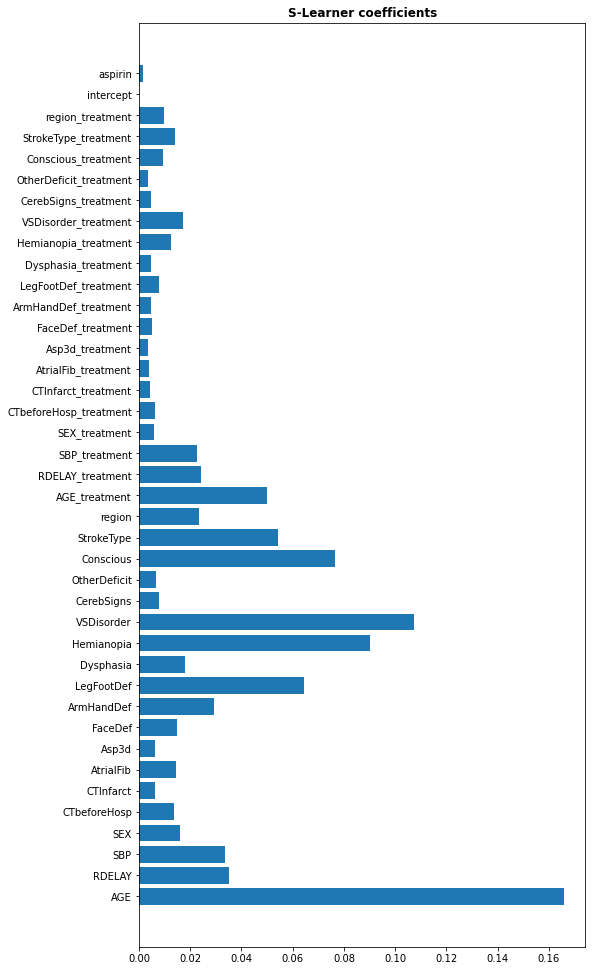

In [15]:
plt.figure(figsize=(8,17))

plt.barh(X_s.columns, clf.feature_importances_);
plt.title('S-Learner coefficients', fontweight='bold', fontsize=12);

In [16]:
def discrimination_calibration_plot_sm(clf, training_set, validation_set, covariates=covariates_collins, target='deathdep', figsize=(15,5)):
    fig, ax = plt.subplots(1,2, figsize=figsize)    
    
    ## discrimination
    if isinstance(clf, sklearn.linear_model.LogisticRegression):
        
        plot_roc_curve(clf, training_set[covariates], training_set[target], name='Training', ax=ax[0])
        plot_roc_curve(clf, validation_set[covariates], validation_set[target], name='Validation', ax=ax[0]);

    else: 

        y_pred_train_proba = clf.predict(training_set[covariates])
        fpr_train, tpr_train, _ = roc_curve(training_set[target],  y_pred_train_proba)
        roc_auc_train = roc_auc_score(y_score=y_pred_train_proba, y_true=training_set[target])
        y_pred_val_proba = clf.predict(validation_set[covariates])
        fpr_val, tpr_val, _ = roc_curve(validation_set[target],  y_pred_val_proba)
        roc_auc_val = roc_auc_score(y_score=y_pred_val_proba, y_true=validation_set[target])

        ax[0].plot(fpr_train, tpr_train, label='Training (AUC = {:.2f})'.format(roc_auc_train))
        ax[0].plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(roc_auc_val))
        ax[0].legend()
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_title('Discrimination')
        
    ax[0].set_title('Discrimination')
    ## calibration curve
    prob_true, prob_pred = calibration_curve(validation_set[target], clf.predict(validation_set[covariates]), n_bins=5)
    
    ax[1].plot(prob_true, prob_pred, label='Validation')

    ax[1].set_title('Calibration')

    plt.legend(loc='upper left')

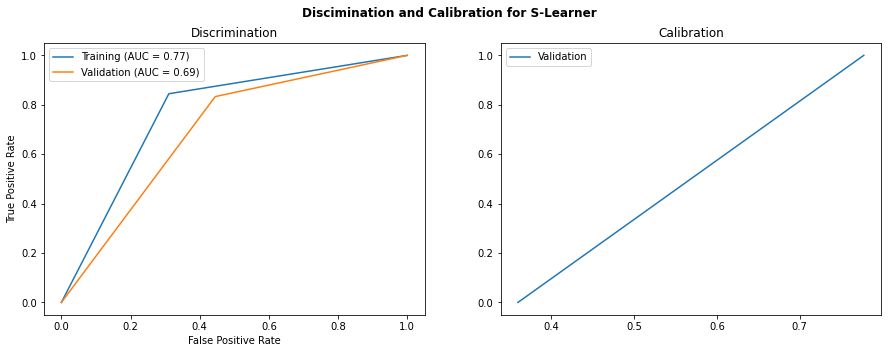

In [17]:
discrimination_calibration_plot_sm(clf, df_train, df_test, covariates=X_s.columns)
plt.suptitle('Discimination and Calibration for S-Learner', fontweight='bold', fontsize=12);

**Remark**: `predict_proba` returns both the proba *P(Y=0|X)* and *P(Y=1|X)* -> **[:, 1]** selects only *P(Y=1|X)*.

In [19]:
def ite_slearner(X) :
    X0 = X[X_s.columns].copy(); X0['aspirin'] = 0
    X1 = X[X_s.columns].copy(); X1['aspirin'] = 1
    if isinstance(clf, sklearn.linear_model.LogisticRegression) or isinstance(clf, sklearn.ensemble.RandomForestClassifier):
        return clf.predict_proba(X1)[:, 1] - clf.predict_proba(X0)[:, 1]
    else:
        return clf.predict(X1) - clf.predict(X0)

ite_slearner(df_test.iloc[[1]])

array([-0.00079621])

# T learner <a id="part3"></a>

In [20]:
X_0, y_0 = X.loc[treatment==0], y.loc[treatment==0]
X_1, y_1 = X.loc[treatment==1], y.loc[treatment==1]


## we use the same best parameters as for the S learner 
mu_0 = RandomForestClassifier(**best_params).fit(X_0, y_0)
mu_1 = RandomForestClassifier(**best_params).fit(X_1, y_1)

print(mu_0.score(X_0, y_0))
print(mu_0.score(X_1, y_1))

0.8062579013906448
0.7350877192982456


In [21]:
## T-learner from Econml
est_t = TLearner(models=RandomForestRegressor(random_state=seed))
est_t.fit(y, treatment, X=X);

In [22]:
t_learner_feat_importance = pd.DataFrame({
    'Features': X_0.columns,
    'Control': mu_0.feature_importances_,
    'Treated': mu_1.feature_importances_,
    }).set_index('Features')

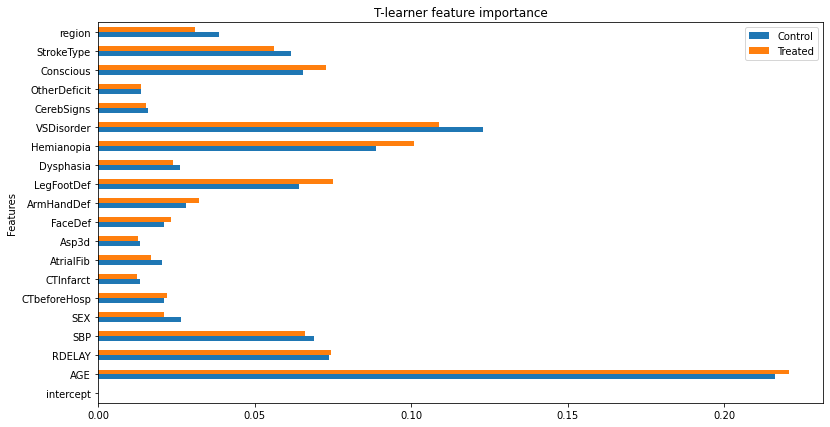

In [23]:
t_learner_feat_importance.plot.barh(figsize=(13,7));
plt.title('T-learner feature importance');

**Control group**

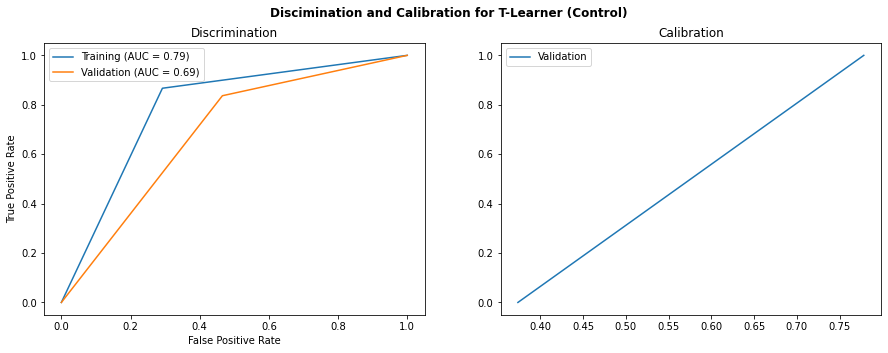

In [24]:
discrimination_calibration_plot_sm(mu_0, pd.concat([X_0, y_0],axis=1),df_test.loc[df_test['aspirin']==0], covariates=X_0.columns)
plt.suptitle('Discimination and Calibration for T-Learner (Control)', fontweight='bold', fontsize=12);

**Treated group**

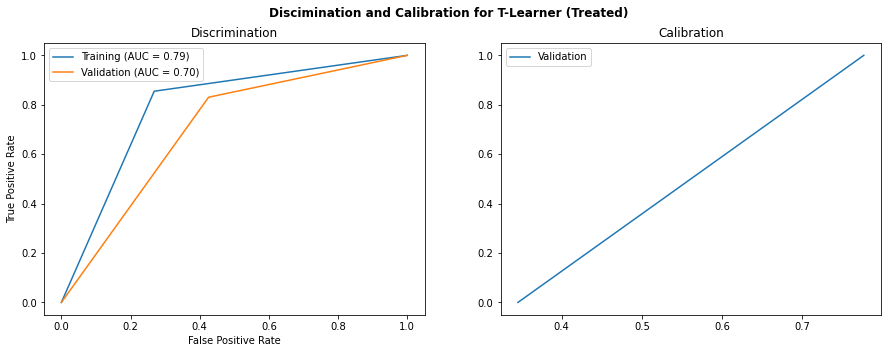

In [25]:
discrimination_calibration_plot_sm(mu_1, pd.concat([X_1, y_1],axis=1),df_test.loc[df_test['aspirin']==1], covariates=X_1.columns)
plt.suptitle('Discimination and Calibration for T-Learner (Treated)', fontweight='bold', fontsize=12);

In [26]:
def ite_tlearner(X) :
    X = X[X_0.columns]
    if isinstance(clf, sklearn.linear_model.LogisticRegression) or isinstance(clf, sklearn.ensemble.RandomForestClassifier):
        return mu_1.predict_proba(X)[:,1] - mu_0.predict_proba(X)[:,1]
    else:
        return mu_1.predict(X) - mu_0.predict(X)

## X-learner <a id="part4"></a>

**Estimating the propensity score**

In [27]:
average_propensity_score = cross_val_score(LogisticRegression(penalty='none', max_iter=1000), df_train[covariates_collins], df_train['aspirin'], cv=5)
print(average_propensity_score.mean())

0.4970625783726221


In [29]:
D_1 = np.array(y_1) - mu_0.predict_proba(X_1)[:,1] 
D_0 = mu_1.predict_proba(X_0)[:,1] - np.array(y_0)


rf = RandomForestRegressor()
gs_x = GridSearchCV(rf, parameters, n_jobs=-1, verbose=4, cv=5)
gs_x.fit(X_0, D_0)      
gs_results = pd.DataFrame(gs_x.cv_results_)
gs_results.to_csv('RF_gridsearch_Xlearner')
best_score = print(gs_results['mean_test_score'].max())
best_params = gs_results.loc[gs_results['mean_test_score'].idxmax()]['params']

#    best_params = {
#        'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100,
#    }
print(best_params)

tau_0 = RandomForestRegressor(**best_params) ## linear regression because the target is no longer binary
tau_1 = RandomForestRegressor(**best_params)


tau_0.fit(X_0, D_0)
tau_1.fit(X_1, D_1);

g_x = 0.5 
def ite_xlearner(X) :
    X = X[X_0.columns]
    return tau_0.predict(X)*g_x + (1-g_x)*tau_1.predict(X)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
0.005481085335620683
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [30]:
# returns the same propensity score for each observation
class Propensity_score():
    def __init__(self, p=0.5):
        self.p = p
        
    def fit(self, X, T):
        pass
    
    def predict_proba(self, X):
        score = [1-self.p, self.p]
        scores = np.tile(score, len(X)).reshape(-1, 2)
        return scores

In [31]:
## X-learner from Econml

est_x = XLearner(models=RandomForestRegressor(random_state=seed),
              propensity_model=Propensity_score(),
              cate_models=RandomForestRegressor(random_state=seed))
est_x.fit(y, treatment, X=X);

In [32]:
x_learner_feat_importance = pd.DataFrame({
    'Features': X_0.columns,
    'Control': tau_0.feature_importances_,
    'Treated': tau_1.feature_importances_
    }).set_index('Features')

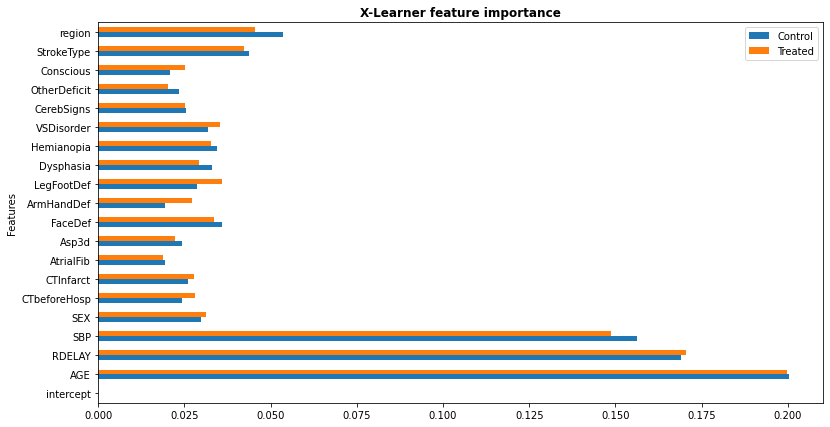

In [33]:
x_learner_feat_importance.plot.barh(figsize=(13,7));
plt.title('X-Learner feature importance',  fontweight='bold', fontsize=12);

## Comparison <a id="part5"></a>

In [34]:
df_test['ITE S-learner'] = ite_slearner(df_test)
df_test['ITE T-learner'] = ite_tlearner(df_test)
df_test['ITE X-learner'] = ite_xlearner(df_test)
df_test['ITE S-learner (econml)'] = est_s.effect(df_test[df_train.columns.drop(['aspirin', 'deathdep'])])
df_test['ITE T-learner (econml)'] = est_t.effect(df_test[X.columns])
df_test['ITE X-learner (econml)'] = est_x.effect(df_test[X.columns])

for m in ['S', 'T', 'X']:
    df_test['ITR {}-learner'.format(m)] = df_test['ITE {}-learner'.format(m)].apply(lambda x: 0 if x>0 else 1)
    df_test['ITR {}-learner (econml)'.format(m)] = df_test['ITE {}-learner (econml)'.format(m)].apply(lambda x: 0 if x>0 else 1)

In [35]:
ite_values = df_test[['ITE S-learner', 'ITE T-learner', 'ITE X-learner']].melt()
ite_values.columns = ['Model', 'ITE']
ite_values_econml = df_test[['ITE S-learner (econml)', 'ITE T-learner (econml)', 'ITE X-learner (econml)']].melt()
ite_values_econml.columns = ['Model', 'ITE']

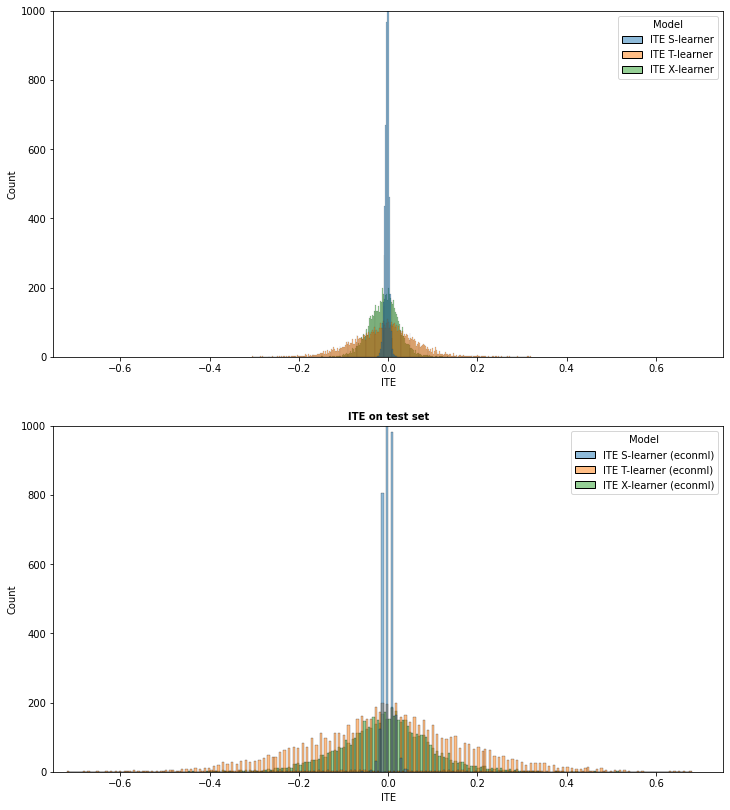

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(12, 14))
ax[0].set_ylim([0, 1000]); ax[1].set_ylim([0, 1000]);
ax[0].set_xlim([-0.75, 0.75]); ax[1].set_xlim([-0.75, 0.75]);
sns.histplot(data=ite_values, x='ITE', hue='Model',ax=ax[0])
sns.histplot(data=ite_values_econml, x='ITE', hue='Model',ax=ax[1])
plt.title('ITE on test set', fontweight='bold', fontsize=10);

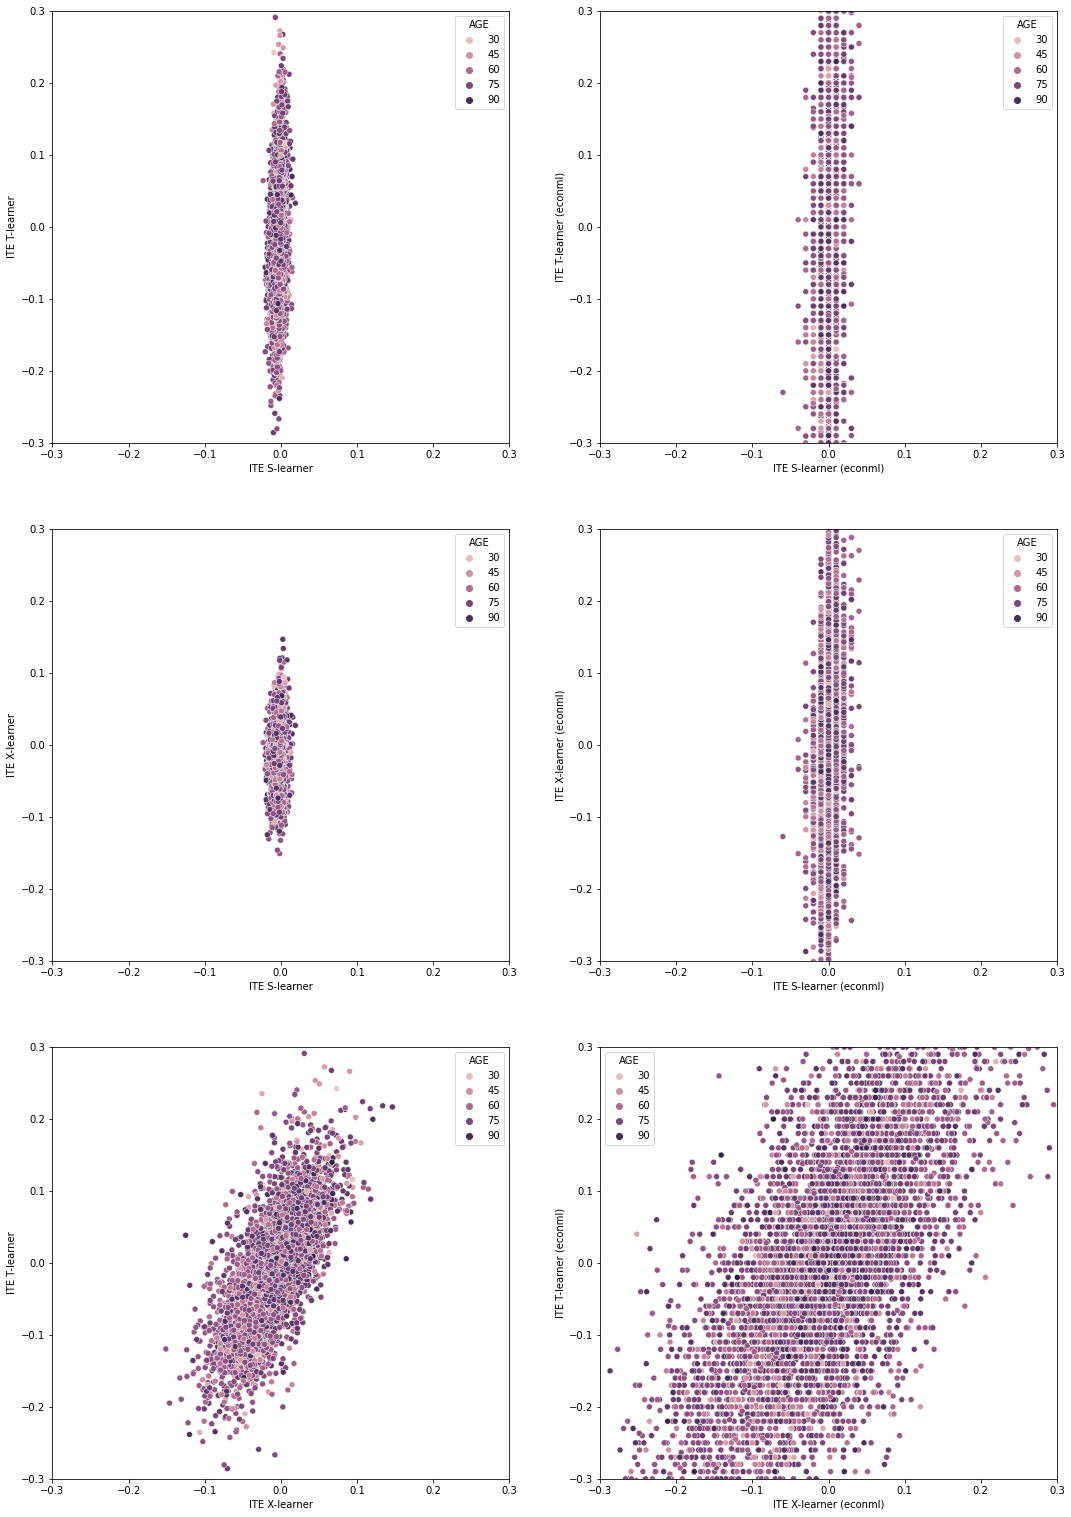

In [37]:
fig, ax = plt.subplots(3,2, figsize=(18, 27))   
plt.setp(ax, xlim=[-0.3, 0.3], ylim=[-0.3, 0.3])
hue = 'AGE'

sns.scatterplot(data=df_test, x="ITE S-learner", y="ITE T-learner",hue=hue, ax=ax[0,0])
sns.scatterplot(data=df_test, x="ITE S-learner", y="ITE X-learner",hue=hue, ax=ax[1,0])
sns.scatterplot(data=df_test, x="ITE X-learner", y="ITE T-learner",hue=hue, ax=ax[2,0]);
sns.scatterplot(data=df_test, x="ITE S-learner (econml)", y="ITE T-learner (econml)",hue=hue, ax=ax[0,1])
sns.scatterplot(data=df_test, x="ITE S-learner (econml)", y="ITE X-learner (econml)",hue=hue, ax=ax[1,1])
sns.scatterplot(data=df_test, x="ITE X-learner (econml)", y="ITE T-learner (econml)",hue=hue, ax=ax[2,1]);

#### Computing V(r)

In [38]:
def V(df,*, ite=None, itr=None, trt: str = 'aspirin', outcome: str = 'deathdep') :
    assert not (isinstance(ite, type(None)) and isinstance(itr, type(None)))
    
    if isinstance(itr, type(None)) : itr = (ite(df) < 0) if callable(ite) else (ite < 0)
    elif callable(itr) : itr = itr(df)
    treatment_rule_concordance = df.loc[df[trt]==itr]

    return treatment_rule_concordance[outcome].mean()


def SMD(df,*, ite=None, itr=None, trt: str = 'aspirin', outcome: str = 'deathdep',
        welch_test: bool = False) :
    assert not ((ite is None) and (itr is None))
    
    if itr is None : itr = (ite(df) < 0) if callable(ite) else (ite < 0)
    elif callable(itr) : itr = itr(df)
    match_idx = df[trt]==itr
    df_match = df.loc[match_idx]
    try :
        mean_diff = df_match.loc[(itr[match_idx]==1), outcome].mean() - df_match.loc[itr[match_idx]==0, outcome].mean()
        if not welch_test : return mean_diff / np.sqrt(df_match[outcome].var())
        # compute Welch t-test statistic 
        var0 = df_match.loc[itr[match_idx]==1, outcome].var() / len(df_match.loc[itr[match_idx]==1])
        var1 = df_match.loc[itr[match_idx]==0, outcome].var() / len(df_match.loc[itr[match_idx]==0])
        return mean_diff / np.sqrt(var0 + var1)
    except :
        return np.NaN

In [39]:
# ITR Probability
print('Prob(itr S learner) = %.2f' %df_test['ITR S-learner'].mean())
print('Prob(itr T learner) = %.2f' %df_test['ITR T-learner'].mean())
print('Prob(itr X learner) = %.2f' %df_test['ITR X-learner'].mean())

# Average outcome for itr on training set
print('\nV(itr S learner) tr = %.2f' %V(df_train, ite=ite_slearner))
print('V(itr T learner) tr = %.2f' %V(df_train, ite=ite_tlearner))
print('V(itr X learner) tr = %.2f' %V(df_train, ite=ite_xlearner))

# Average outcome for itr on testing set
print('\nV(itr S learner) te = %.2f' %V(df_test, ite=ite_slearner))
print('V(itr T learner) te = %.2f' %V(df_test, ite=ite_tlearner))
print('V(itr X learner) te = %.2f' %V(df_test, ite=ite_xlearner))

Prob(itr S learner) = 0.70
Prob(itr T learner) = 0.54
Prob(itr X learner) = 0.60

V(itr S learner) tr = 0.46
V(itr T learner) tr = 0.40
V(itr X learner) tr = 0.48

V(itr S learner) te = 0.57
V(itr T learner) te = 0.65
V(itr X learner) te = 0.65


#### Ploting Table

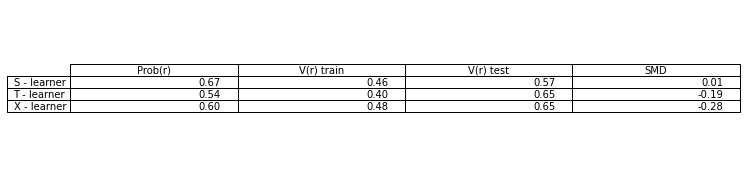

In [40]:
ite_learner = [ite_slearner, ite_tlearner, ite_xlearner]

fig, ax = plt.subplots(figsize=(12,3))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame()
df['Prob(r)'] = [np.mean(ite(df_test)<0) for ite in ite_learner]
df['V(r) train'] = [V(df_train, ite=ite) for ite in ite_learner]
df['V(r) test'] = [V(df_test, ite=ite) for ite in ite_learner]
df['SMD'] = [SMD(df_test, ite=ite) for ite in ite_learner]

df.update(df.applymap('{:,.2f}'.format))

ax.table(cellText=df.values, colLabels=df.columns, loc='center',
         rowLabels=['S - learner', 'T - learner', 'X - learner']);

#### Ploting comparison ITR and significant covariates

### Table to compare ITRs and covariates influence

In [41]:
list_itr = [lambda x : ite_slearner(x) < 0,
            lambda x : ite_tlearner(x) < 0,
            lambda x : ite_xlearner(x) < 0]
itr_name = ['S learner', 'T learner', 'X learner']

def plot_tabular (df, list_itr, itr_name, tablefmt='simple', pandas_display=False) :
    header = ['covariates']
    for s in itr_name : header += [s + ' ctrl'] + [s + ' trt']
    Mat = [] 
    for c in covariates_collins :
        row = [c]
        for itr in list_itr :
            itr1 = itr(df)
            itr0 = [not b for b in itr1]
            row.append(df.loc[itr0, c].mean())
            row.append(df.loc[itr1, c].mean())
        Mat.append(row)
    if pandas_display:
        df_pandas = pd.DataFrame(Mat,columns=header)
        df_pandas = df_pandas.set_index('covariates')
        display(df_pandas.round(3))
    else:
        print(tabulate(Mat, headers=header, floatfmt=".3f", tablefmt=tablefmt))

In [42]:
plot_tabular(df_test, list_itr, itr_name, pandas_display=True)

,S learner ctrl,S learner trt,T learner ctrl,T learner trt,X learner ctrl,X learner trt
covariates,,,,,,
intercept,1.000,1.000,1.000,1.000,1.000,1.000
AGE,73.597,71.500,73.169,71.369,73.547,71.298
RDELAY,19.926,20.379,20.339,20.138,20.457,20.081
SBP,159.996,161.017,159.040,162.058,154.479,164.757
SEX,0.549,0.506,0.531,0.511,0.552,0.499
CTbeforeHosp,0.615,0.625,0.624,0.620,0.625,0.619
CTInfarct,0.301,0.309,0.341,0.278,0.357,0.274
AtrialFib,0.201,0.162,0.189,0.163,0.197,0.160
Asp3d,0.210,0.224,0.226,0.214,0.264,0.190
